# 13차시: [실습] FRED API로 글로벌 경제 지표(금리, 물가) 수집

## 학습 목표
- FRED API를 활용하여 경제 지표를 수집하는 함수 작성
- 미국 기준 금리, 국채 수익률, CPI 등 주요 경제 지표 수집
- 여러 경제 지표 비교 분석 및 시각화

## 학습 내용
1. API 키 설정 (11차시 복습)
2. FRED API 데이터 수집 함수
3. 금리 지표 수집 및 분석
4. 물가 지표 수집 및 분석
5. 여러 지표 비교 분석 (정규화)
6. 데이터 저장 (CSV/Excel)


In [1]:
!pip install -q koreanize-matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests

---
## 1. API 키 설정

11차시와 동일하게 `.env` 파일에서 FRED API 키를 로드합니다.

### FRED API 키 발급 방법
1. https://fred.stlouisfed.org/ 접속
2. 회원가입 및 로그인
3. My Account → API Keys → Request API Key

In [3]:
# API 키 로드 (Colab에서 .env 파일 업로드)
from google.colab import files
import os
from dotenv import load_dotenv

print("[.env 파일 업로드]")
print("=" * 60)
print("로컬에 저장된 .env 파일을 선택해주세요.")
print("(FRED_API_KEY가 포함된 파일)")
print()

uploaded = files.upload()

# .env 파일 로드
load_dotenv('.env')

FRED_API_KEY = os.getenv('FRED_API_KEY')

# API 키 로드 확인
print("\n[API 키 로드 상태]")
print("=" * 60)
if FRED_API_KEY:
    print(f"FRED API Key: 설정완료 ({FRED_API_KEY[:8]}...)")
else:
    print("FRED API Key: 미설정")

[.env 파일 업로드]
로컬에 저장된 .env 파일을 선택해주세요.
(FRED_API_KEY가 포함된 파일)



Saving .env to .env (1)

[API 키 로드 상태]
FRED API Key: 설정완료 (061718d0...)


---
## 2. FRED API 데이터 수집 함수

FRED API를 활용하여 경제 지표를 수집하는 함수를 작성합니다.

### FRED 주요 경제 지표 코드
| 분류 | 코드 | 설명 |
|------|------|------|
| **금리** | FEDFUNDS | 연방기금금리 (기준금리) |
| | DGS10 | 10년 국채 수익률 |
| | DGS2 | 2년 국채 수익률 |
| | T10Y2Y | 10년-2년 국채 스프레드 |
| **물가** | CPIAUCSL | 소비자물가지수 (CPI) |
| | PCEPI | 개인소비지출 물가지수 (PCE) |
| **고용** | UNRATE | 실업률 |

In [4]:
# FRED API 데이터 수집 함수
def fetch_fred_series(series_id, start_date, end_date, api_key):
    """
    FRED API를 통해 단일 시계열 데이터를 수집하는 함수

    Parameters:
    -----------
    series_id : FRED 시계열 코드 (예: 'FEDFUNDS', 'DGS10')
    start_date :  시작일 (YYYY-MM-DD)
    end_date :   종료일 (YYYY-MM-DD)
    api_key :   FRED API 키

    Returns:
    --------
    DataFrame : 날짜와 값이 포함된 DataFrame
    """
    # FRED 시계열 관측값(observations) 조회 API 엔드포인트
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "api_key": api_key,                # FRED API 인증키
        "series_id": series_id,             # 조회할 시계열 코드
        "file_type": "json",                # 응답 형식 (JSON)
        "observation_start": start_date,    # 조회 시작일
        "observation_end": end_date         # 조회 종료일
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()

        if 'observations' in data:
            # 관측값 리스트를 DataFrame으로 변환
            df = pd.DataFrame(data['observations'])
            # 날짜 컬럼을 datetime 타입으로 변환
            df['date'] = pd.to_datetime(df['date'])
            # 값(value)을 숫자형으로 변환/결측값은 NaN으로 처리
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            # 날짜를 인덱스로 설정하고 값 컬럼만 선택
            df = df.set_index('date')[['value']]
            # 컬럼명을 시계열 코드(series_id)로 변경
            df.columns = [series_id]
            return df
        else:
            print(f"  오류: {data.get('error_message', '알 수 없는 오류')}")
            return pd.DataFrame()
    else:
        print(f"  HTTP 오류: {response.status_code}")
        return pd.DataFrame()

---
## 3. 금리 지표 수집 및 분석

미국 기준금리(FEDFUNDS)와 국채 수익률(DGS10, DGS2)을 수집하고 분석합니다.

### 주요 금리 지표
- **FEDFUNDS (연방기금금리)**: 미국 중앙은행(Fed)이 결정하는 기준금리
- **DGS10 (10년 국채 수익률)**: 장기 금리의 대표 지표
- **DGS2 (2년 국채 수익률)**: 단기 금리의 대표 지표
- **T10Y2Y (장단기 스프레드)**: 10년-2년 금리 차이 (경기 침체 신호)

In [5]:
# 금리 지표 수집
print("[금리 지표 수집]")
print("=" * 60)

# 금리 관련 지표 정의
interest_rate_series = {
    "FEDFUNDS": "연방기금금리 (기준금리)",
    "DGS10": "10년 국채 수익률",
    "DGS2": "2년 국채 수익률",
    "T10Y2Y": "10년-2년 스프레드"
}

# 기간 설정 (최근 5년)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')

print(f"기간: {start_date} ~ {end_date}")
print()

# 데이터 수집 (for loop 사용)
all_rates = []
for series_id, description in interest_rate_series.items():
    df = fetch_fred_series(series_id, start_date, end_date, FRED_API_KEY)
    if not df.empty:
        all_rates.append(df)
        print(f"  {series_id} ({description}): {len(df)}개 수집")
    else:
        print(f"  {series_id} ({description}): 수집 실패")

# DataFrame 결합
df_rates = pd.concat(all_rates, axis=1)
print(f"\n총 {len(df_rates)}개 날짜, {len(df_rates.columns)}개 지표 수집 완료")

# 샘플 데이터 확인
print("\n[최근 데이터 샘플]")
df_rates.tail()

[금리 지표 수집]
기간: 2021-01-08 ~ 2026-01-07

  FEDFUNDS (연방기금금리 (기준금리)): 60개 수집
  DGS10 (10년 국채 수익률): 1302개 수집
  DGS2 (2년 국채 수익률): 1302개 수집
  T10Y2Y (10년-2년 스프레드): 1303개 수집

총 1320개 날짜, 4개 지표 수집 완료

[최근 데이터 샘플]


,FEDFUNDS,DGS10,DGS2,T10Y2Y
date,,,,
2025-12-31,NaN,4.18,3.47,0.71
2026-01-01,NaN,NaN,NaN,NaN
2026-01-02,NaN,4.19,3.47,0.72
2026-01-05,NaN,4.17,3.46,0.71
2026-01-06,NaN,NaN,NaN,0.71


In [6]:
# FEDFUNDS(연방기금금리) 값이 결측치가 아닌 행만 선택
df_rates[df_rates['FEDFUNDS'].notna()].head()

,FEDFUNDS,DGS10,DGS2,T10Y2Y
date,,,,
2021-01-01,0.09,NaN,NaN,NaN
2021-02-01,0.08,1.09,0.11,0.98
2021-03-01,0.07,1.45,0.13,1.32
2021-04-01,0.07,1.69,0.17,1.52
2021-05-01,0.06,NaN,NaN,NaN


In [7]:
# 금리 지표 기본 통계
print("[금리 지표 기본 통계]")
print("=" * 60)

# 결측치 처리 (전방 채움)
df_rates_clean = df_rates.ffill()

# 최근 값
print("\n[최근 값]")
latest = df_rates_clean.iloc[-1]
for col in df_rates_clean.columns:
    print(f"  {col}: {latest[col]:.2f}%")

# 기본 통계
print("\n[기술 통계량]")
df_rates_clean.describe().round(2)

[금리 지표 기본 통계]

[최근 값]
  FEDFUNDS: 3.72%
  DGS10: 4.17%
  DGS2: 3.46%
  T10Y2Y: 0.71%

[기술 통계량]


,FEDFUNDS,DGS10,DGS2,T10Y2Y
count,1320.00,1319.00,1319.00,1319.00
mean,3.25,3.39,3.22,0.17
std,2.11,1.14,1.66,0.67
min,0.06,1.04,0.09,-1.08
25%,0.33,2.68,2.47,-0.40
50%,4.33,3.86,3.91,0.15
75%,5.09,4.26,4.40,0.58
max,5.33,4.98,5.19,1.59


### 기준금리와 국채 수익률 비교
- 연방기금금리(FEDFUNDS): 연준(Fed)이 직접 결정하는 정책 금리

- 2년 국채 수익률(DGS2): 시장의 단기 금리·경기 기대

- 10년 국채 수익률(DGS10): 시장의 장기 성장·물가 기대

### 장단기 금리 스프레드 (10년–2년) 의미

- 양수(정상): 장기 금리 > 단기 금리 → 정상적인 경기 구조  
- 음수(역전): 단기 금리 > 장기 금리 → 경기 침체 가능성 증가


[금리 지표 시각화]


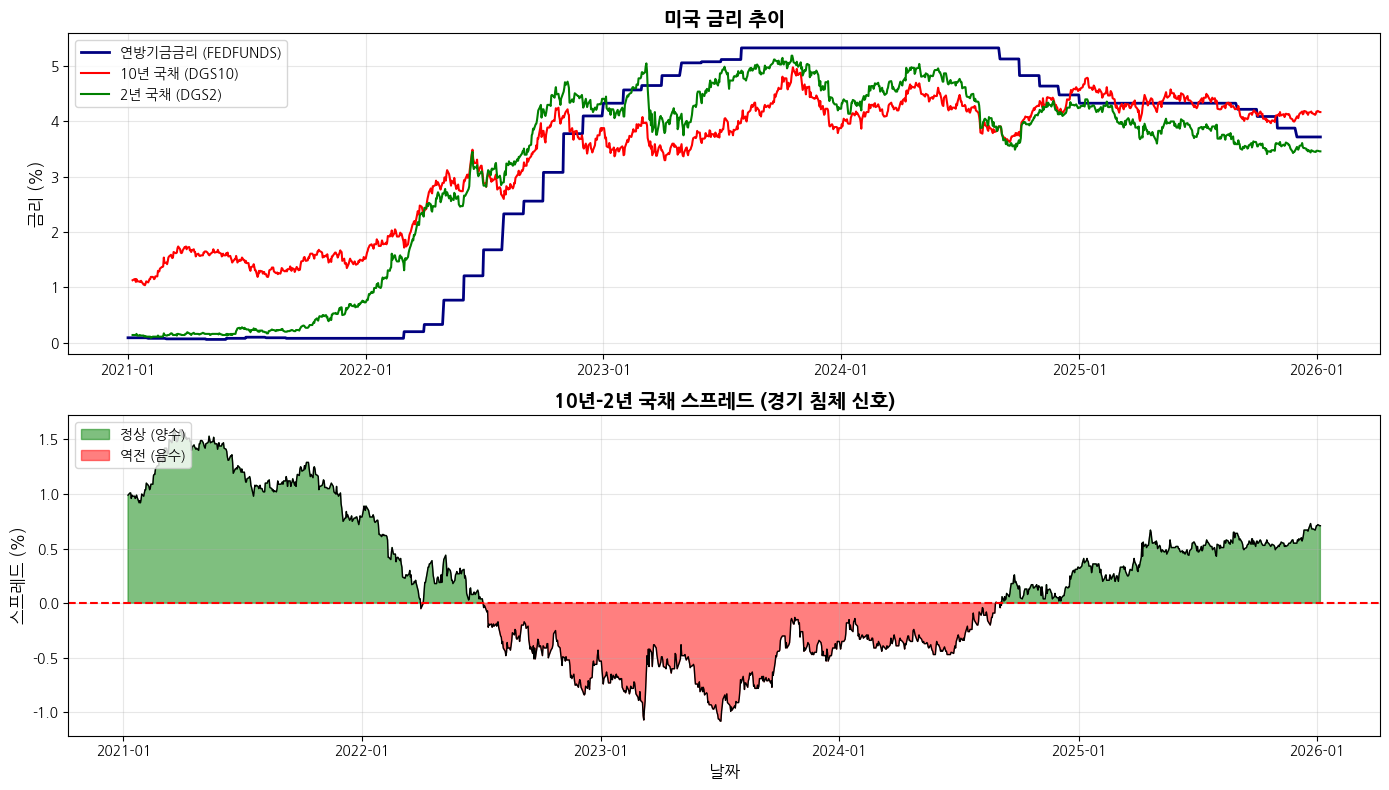


[장단기 스프레드 해석]
  - 양수: 정상적인 수익률 곡선 (장기 금리 > 단기 금리)
  - 음수: 수익률 곡선 역전 (경기 침체 신호) --> 안전자산(장기 국채)로 자금이 이동했다는 뜻


In [8]:
# 금리 지표 시각화
print("\n[금리 지표 시각화]")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# (1) 기준금리와 국채 수익률
ax1.plot(df_rates_clean.index, df_rates_clean['FEDFUNDS'],
             label='연방기금금리 (FEDFUNDS)', color='navy', linewidth=2)
ax1.plot(df_rates_clean.index, df_rates_clean['DGS10'],
             label='10년 국채 (DGS10)', color='red', linewidth=1.5)
ax1.plot(df_rates_clean.index, df_rates_clean['DGS2'],
             label='2년 국채 (DGS2)', color='green', linewidth=1.5)

ax1.set_title('미국 금리 추이', fontsize=14, fontweight='bold')
ax1.set_ylabel('금리 (%)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# (2) 장단기 스프레드
spread = df_rates_clean['T10Y2Y']
ax2.fill_between(spread.index, 0, spread,
                    where=(spread >= 0), color='green', alpha=0.5, label='정상 (양수)')
ax2.fill_between(spread.index, 0, spread,
                    where=(spread < 0), color='red', alpha=0.5, label='역전 (음수)')
ax2.plot(spread.index, spread, color='black', linewidth=1)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

ax2.set_title('10년-2년 국채 스프레드 (경기 침체 신호)', fontsize=14, fontweight='bold')
ax2.set_ylabel('스프레드 (%)', fontsize=12)
ax2.set_xlabel('날짜', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

print("\n[장단기 스프레드 해석]")
print("  - 양수: 정상적인 수익률 곡선 (장기 금리 > 단기 금리)")
print("  - 음수: 수익률 곡선 역전 (경기 침체 신호) --> 안전자산(장기 국채)로 자금이 이동했다는 뜻")

---
## 4. 물가 지표 수집 및 분석

소비자물가지수(CPI)와 개인소비지출 물가지수(PCE)를 수집하고 분석합니다.

### 주요 물가 지표
- **CPIAUCSL (CPI)**: 소비자물가지수 - 가장 널리 사용되는 물가 지표
- **PCEPI (PCE)**: 개인소비지출 물가지수 - Fed가 선호하는 물가 지표

| 구분          | **CPI (소비자물가지수)**   | **PCE (개인소비지출 물가지수)**   |
| ----------- | ------------------- | ----------------------- |
| 작성 기관       | **미 노동통계국(BLS)**    | **미 상무부 경제분석국(BEA)**    |
| 기본 관점       | 가계가 **직접 체감하는 물가**  | 경제 전체의 **소비 구조 기반 물가**  |
| 기준 연도       | **1982–1984 평균 = 100** | **2018 = 100**          |
| 주거비 비중      | 매우 큼 (임대료 중심)       | 상대적으로 작음                |
| 변동성         | 큼                   | 작음                      |
| 발표 빈도       | 매월                  | 매월                      |
| 시장 반응       | **즉각적·강함**          | 상대적으로 약함                |
| 연준(Fed) 선호도 | 참고 지표               | **정책 기준 지표**            |
| 투자 활용       | 단기 이벤트·시장 심리        | 중·장기 금리·사이클 분석          |


In [9]:
# 물가 지표 수집
print("[물가 지표 수집]")
print("=" * 60)

# 물가 관련 지표 정의
inflation_series = {
    "CPIAUCSL": "소비자물가지수 (CPI)",
    "PCEPI": "개인소비지출 물가지수 (PCE)"
}

# 기간 설정 (최근 10년 - 물가 추이는 더 긴 기간이 유용)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')

print(f"기간: {start_date} ~ {end_date}")
print()

# 데이터 수집 (for loop 사용)
all_inflation = []
for series_id, description in inflation_series.items():
    df = fetch_fred_series(series_id, start_date, end_date, FRED_API_KEY)
    if not df.empty:
        all_inflation.append(df)
        print(f"  {series_id} ({description}): {len(df)}개 수집")
    else:
        print(f"  {series_id} ({description}): 수집 실패")

# DataFrame 결합
df_inflation = pd.concat(all_inflation, axis=1)
print(f"\n총 {len(df_inflation)}개 날짜, {len(df_inflation.columns)}개 지표 수집 완료")

df_inflation.tail()

[물가 지표 수집]
기간: 2016-01-10 ~ 2026-01-07

  CPIAUCSL (소비자물가지수 (CPI)): 119개 수집
  PCEPI (개인소비지출 물가지수 (PCE)): 117개 수집

총 119개 날짜, 2개 지표 수집 완료


,CPIAUCSL,PCEPI
date,,
2025-07-01,322.132,126.957
2025-08-01,323.364,127.287
2025-09-01,324.368,127.626
2025-10-01,NaN,NaN
2025-11-01,325.031,NaN


In [10]:
# 물가 상승률(인플레이션) 계산
print("\n[물가 상승률 계산]")
print("=" * 60)

# 결측치 처리
df_inflation_clean = df_inflation.ffill()

# 전년 동월 대비 상승률 (YoY) 계산
df_inflation_yoy = df_inflation_clean.pct_change(periods=12) * 100
df_inflation_yoy.columns = ['CPI_YoY', 'PCE_YoY']

print("\n[전년 동월 대비 물가 상승률 (%)]")
print(df_inflation_yoy.tail(12).round(2))

# 최근 인플레이션
print("\n[최근 물가 상승률]")
latest_yoy = df_inflation_yoy.iloc[-1]
print(f"  CPI 상승률: {latest_yoy['CPI_YoY']:.2f}%")
print(f"  PCE 상승률: {latest_yoy['PCE_YoY']:.2f}%")
print(f"\n  * Fed 목표 인플레이션: 2%")


[물가 상승률 계산]

[전년 동월 대비 물가 상승률 (%)]
            CPI_YoY  PCE_YoY
date                        
2024-12-01     2.87     2.73
2025-01-01     3.00     2.61
2025-02-01     2.81     2.71
2025-03-01     2.41     2.36
2025-04-01     2.33     2.28
2025-05-01     2.38     2.46
2025-06-01     2.67     2.59
2025-07-01     2.73     2.60
2025-08-01     2.94     2.74
2025-09-01     3.02     2.79
2025-10-01     2.79     2.52
2025-11-01     2.71     2.40

[최근 물가 상승률]
  CPI 상승률: 2.71%
  PCE 상승률: 2.40%

  * Fed 목표 인플레이션: 2%


###  미국의 물가 흐름을 정책 관점에서 해석하기 위한 차트

- CPI 상승률 (CPI YoY) :  소비자가 실제로 체감하는 물가 변화 (주거비, 식료품, 에너지 등 생활물가 중심)

- PCE 상승률 (PCE YoY) : 연준(Fed)이 통화정책 판단에 더 중시하는 지표 (소비 패턴 변화를 반영해 CPI보다 완만한 경향)

- Fed 목표 인플레이션 (2%)

| 상황          | 의미                            |
| ----------- | ----------------------------- |
| 물가 상승률 > 2% | 인플레이션 압력 증가 → 금리 인상 또는 고금리 유지 |
| 물가 상승률 ≈ 2% | 물가 안정 구간                      |
| 물가 상승률 < 2% | 디스인플레이션/디플레이션 우려 → 금리 인하 가능성  |



[물가 상승률 시각화]


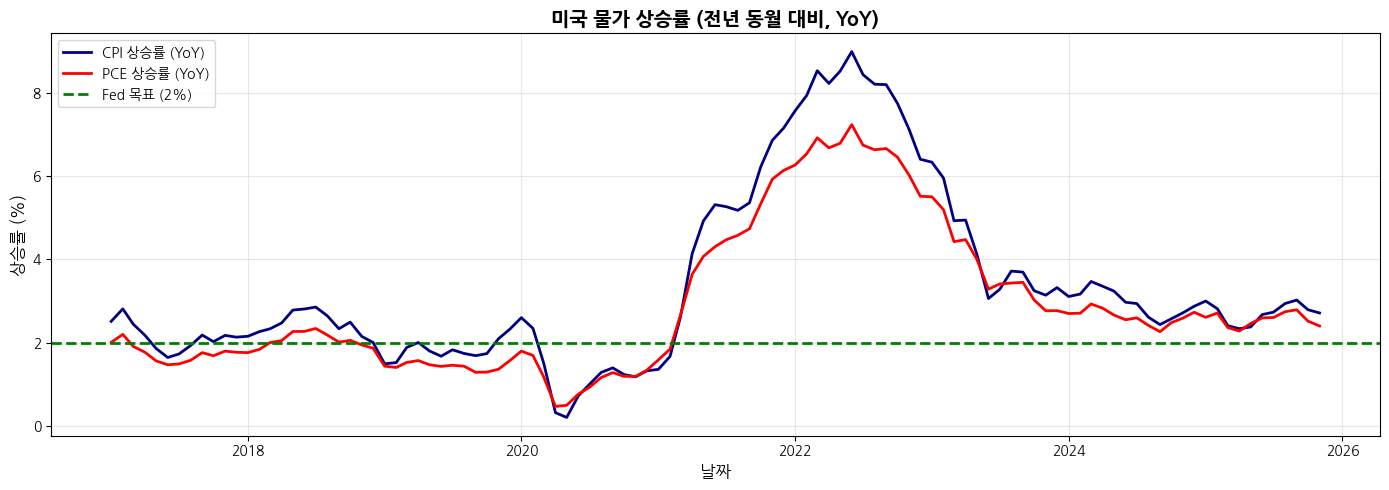


[해석 포인트]
  - 2% 초과: 인플레이션 압력 ↑ → 금리 인상 가능성
  - 2% 근접: 물가 안정 구간
  - 2% 미만: 디스인플레이션/디플레이션 우려 → 금리 인하 가능성


In [11]:
# 물가 상승률(YoY) 시각화
print("\n[물가 상승률 시각화]")
print("=" * 60)

plt.figure(figsize=(14, 5))

# CPI / PCE 전년 동월 대비 상승률
plt.plot(df_inflation_yoy.index, df_inflation_yoy['CPI_YoY'],
         label='CPI 상승률 (YoY)', color='navy', linewidth=2)
plt.plot(df_inflation_yoy.index, df_inflation_yoy['PCE_YoY'],
         label='PCE 상승률 (YoY)', color='red', linewidth=2)

# Fed 목표 인플레이션 (2%)
plt.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Fed 목표 (2%)')

# 차트 설정
plt.title('미국 물가 상승률 (전년 동월 대비, YoY)', fontsize=14, fontweight='bold')
plt.ylabel('상승률 (%)', fontsize=12)
plt.xlabel('날짜', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))

plt.tight_layout()
plt.show()

print("\n[해석 포인트]")
print("  - 2% 초과: 인플레이션 압력 ↑ → 금리 인상 가능성")
print("  - 2% 근접: 물가 안정 구간")
print("  - 2% 미만: 디스인플레이션/디플레이션 우려 → 금리 인하 가능성")

---
## 5. 여러 지표 비교 분석 (정규화)

금리와 물가를 함께 비교하여 경제 상황을 종합적으로 분석합니다.
단위가 다른 지표들을 정규화하여 비교합니다.

In [12]:
# 여러 지표 종합 수집
print("[여러 경제지표 종합 수집]")
print("=" * 60)

# 종합 지표 정의
all_series = {
    "FEDFUNDS": "연방기금금리",
    "DGS10": "10년 국채",
    "UNRATE": "실업률",
    "DEXKOUS": "원/달러 환율"
}

# 기간 설정 (최근 5년)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')

print(f"기간: {start_date} ~ {end_date}")
print()

# 데이터 수집 (for loop 사용)
all_data = []
for series_id, description in all_series.items():
    df = fetch_fred_series(series_id, start_date, end_date, FRED_API_KEY)
    if not df.empty:
        all_data.append(df)
        print(f"  {series_id} ({description}): {len(df)}개 수집")
    else:
        print(f"  {series_id} ({description}): 수집 실패")

# DataFrame 결합
df_all = pd.concat(all_data, axis=1)
print(f"\n총 {len(df_all)}개 날짜, {len(df_all.columns)}개 지표 수집 완료")

# 결측치 처리
df_all_clean = df_all.ffill().bfill()

print("\n[최근 데이터 샘플]")
df_all_clean.tail()

[여러 경제지표 종합 수집]
기간: 2021-01-08 ~ 2026-01-07

  FEDFUNDS (연방기금금리): 60개 수집
  DGS10 (10년 국채): 1302개 수집
  UNRATE (실업률): 59개 수집
  DEXKOUS (원/달러 환율): 1301개 수집

총 1319개 날짜, 4개 지표 수집 완료

[최근 데이터 샘플]


,FEDFUNDS,DGS10,UNRATE,DEXKOUS
date,,,,
2025-12-30,3.72,4.14,4.6,1439.42
2025-12-31,3.72,4.18,4.6,1444.55
2026-01-01,3.72,4.18,4.6,1444.55
2026-01-02,3.72,4.19,4.6,1444.45
2026-01-05,3.72,4.17,4.6,1444.45


In [13]:
# 정규화 비교 (최초값 = 100 기준)
print("\n[정규화 비교 (최초값 = 100)]")
print("=" * 60)

# 정규화: 첫 번째 값을 100으로 설정
df_normalized = (df_all_clean / df_all_clean.iloc[0])

print("정규화를 통해 단위가 다른 지표들을 동일한 스케일로 비교합니다.")


[정규화 비교 (최초값 = 100)]
정규화를 통해 단위가 다른 지표들을 동일한 스케일로 비교합니다.


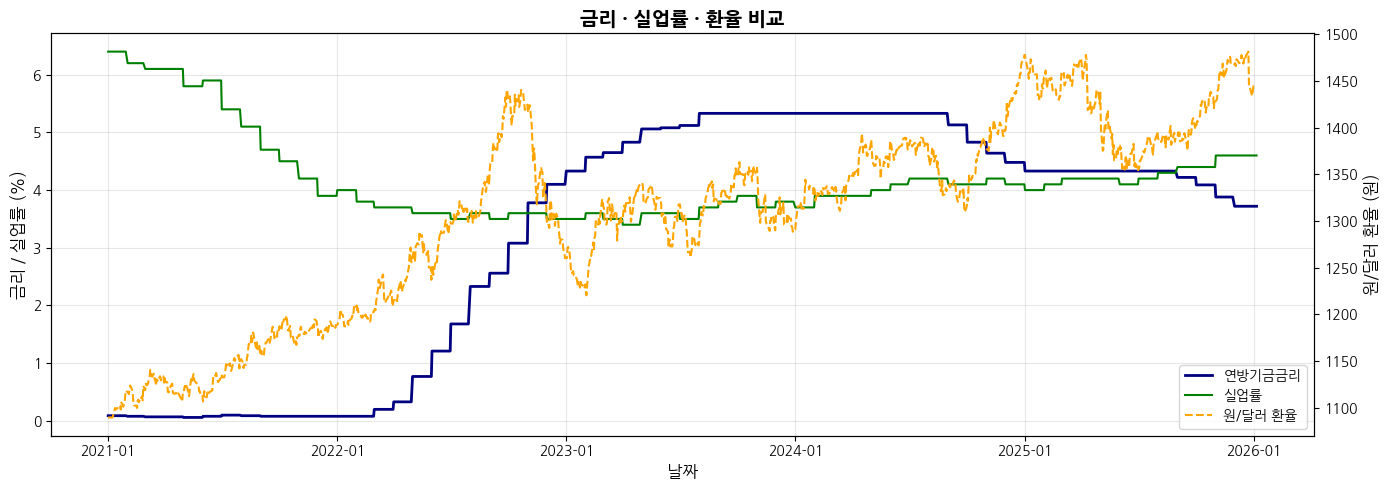

미국의 급격한 금리 인상은 달러 강세를 유발하고, 그 결과 타국 통화의 약세를 통해 외부에 충격이 전이됩니다.
금리 인상의 효과는 실업률에 즉시 나타나지 않으며, 보통 6~18개월의 시차를 두고 나타나는 대표적인 후행 지표입니다.


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 단일 플롯 생성
fig, ax = plt.subplots(figsize=(14, 5))
# 기존 축(ax)과 x축을 공유하면서 오른쪽에 새로운 y축을 추가로 생성
ax_twin = ax.twinx()

# 왼쪽 축: 금리 / 실업률 (%)
ax.plot(
        df_all_clean.index,
        df_all_clean['FEDFUNDS'],
        label='연방기금금리',
        color='navy',
        linewidth=2
    )

ax.plot(
        df_all_clean.index,
        df_all_clean['UNRATE'],
        label='실업률',
        color='green',
        linewidth=1.5
    )

# 오른쪽 축: 환율 (원)
ax_twin.plot(
        df_all_clean.index,
        df_all_clean['DEXKOUS'],
        label='원/달러 환율',
        color='orange',
        linewidth=1.5,
        linestyle='--'
    )

# 제목 및 라벨
ax.set_title('금리 · 실업률 · 환율 비교', fontsize=14, fontweight='bold')
ax.set_ylabel('금리 / 실업률 (%)', fontsize=12)
ax_twin.set_ylabel('원/달러 환율 (원)', fontsize=12)
ax.set_xlabel('날짜', fontsize=12)

# 범례 통합
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

# 축 포맷
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

print("미국의 급격한 금리 인상은 달러 강세를 유발하고, 그 결과 타국 통화의 약세를 통해 외부에 충격이 전이됩니다.")
print("금리 인상의 효과는 실업률에 즉시 나타나지 않으며, 보통 6~18개월의 시차를 두고 나타나는 대표적인 후행 지표입니다.")

---
## 6. 데이터 저장 (CSV/Excel)

수집한 경제지표 데이터를 CSV 및 Excel 파일로 저장합니다.

In [15]:
# 데이터 정리 및 저장
print("[데이터 저장]")
print("=" * 60)

# 모든 데이터를 하나의 DataFrame으로 결합
df_export = df_all_clean.copy()

# 컬럼명 한글화
col_mapping = {
    'FEDFUNDS': '연방기금금리',
    'DGS10': '10년국채수익률',
    'DGS2': '2년국채수익률',
    'T10Y2Y': '장단기스프레드',
    'CPIAUCSL': '소비자물가지수',
    'PCEPI': '개인소비지출물가',
    'UNRATE': '실업률',
    'DEXKOUS': '원달러환율'
}

df_export_kr = df_export.rename(columns=col_mapping)
df_export_kr.index.name = '날짜'

print(f"\n[저장할 데이터]")
print(f"  - 기간: {df_export_kr.index[0].strftime('%Y-%m-%d')} ~ {df_export_kr.index[-1].strftime('%Y-%m-%d')}")
print(f"  - 데이터 수: {len(df_export_kr)}개 날짜")
print(f"  - 지표 수: {len(df_export_kr.columns)}개")

[데이터 저장]

[저장할 데이터]
  - 기간: 2021-01-01 ~ 2026-01-05
  - 데이터 수: 1319개 날짜
  - 지표 수: 4개


In [16]:
# CSV 파일 저장
csv_filename = f"FRED_경제지표_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
df_export_kr.to_csv(csv_filename, encoding='utf-8-sig')

print(f"\n[CSV 저장 완료]")
print(f"  - 파일명: {csv_filename}")
print(f"  - 파일 크기: {os.path.getsize(csv_filename) / 1024:.2f} KB")


[CSV 저장 완료]
  - 파일명: FRED_경제지표_20210108_20260107.csv
  - 파일 크기: 42.27 KB


In [17]:
# Excel 파일 저장 (여러 시트)
excel_filename = f"FRED_경제지표_{start_date.replace('-', '')}_{end_date.replace('-', '')}.xlsx"

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # 시트 1: 원본 데이터
    df_export_kr.to_excel(writer, sheet_name='원본데이터')

    # 시트 2: 기술 통계량
    df_export_kr.describe().round(2).to_excel(writer, sheet_name='기술통계량')

    # 시트 3: 상관관계
    df_export_kr.corr().round(3).to_excel(writer, sheet_name='상관관계')

    # 시트 4: 정규화 데이터
    df_normalized_kr = (df_export_kr / df_export_kr.iloc[0]) * 100
    df_normalized_kr.to_excel(writer, sheet_name='정규화데이터')

print(f"\n[Excel 저장 완료]")
print(f"  - 파일명: {excel_filename}")
print(f"  - 시트 구성:")
print(f"    1. 원본데이터: 수집된 경제지표")
print(f"    2. 기술통계량: 기본 통계")
print(f"    3. 상관관계: 지표 간 상관계수")
print(f"    4. 정규화데이터: 최초값=100 기준")


[Excel 저장 완료]
  - 파일명: FRED_경제지표_20210108_20260107.xlsx
  - 시트 구성:
    1. 원본데이터: 수집된 경제지표
    2. 기술통계량: 기본 통계
    3. 상관관계: 지표 간 상관계수
    4. 정규화데이터: 최초값=100 기준


In [18]:
# Colab에서 파일 다운로드
print("\n[파일 다운로드]")
print("=" * 60)

from google.colab import files

print("아래 파일을 다운로드합니다:")
print(f"  1. {csv_filename}")
print(f"  2. {excel_filename}")
print()

files.download(csv_filename)
files.download(excel_filename)


[파일 다운로드]
아래 파일을 다운로드합니다:
  1. FRED_경제지표_20210108_20260107.csv
  2. FRED_경제지표_20210108_20260107.xlsx



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## 학습 정리

### 1. FRED API 활용
- `fetch_fred_series()`: 단일 시계열 수집 함수
- for loop로 여러 시계열 수집 후 `pd.concat()` 결합
- API 키를 `.env` 파일로 관리

### 2. 주요 경제 지표
| 분류 | 코드 | 설명 |
|------|------|------|
| 금리 | FEDFUNDS | 연방기금금리 (기준금리) |
| | DGS10, DGS2 | 국채 수익률 |
| | T10Y2Y | 장단기 스프레드 |
| 물가 | CPIAUCSL | 소비자물가지수 (CPI) |
| | PCEPI | 개인소비지출 물가지수 (PCE) |
| 고용 | UNRATE | 실업률 |
| 환율 | DEXKOUS | 원/달러 환율 |

### 3. 데이터 분석
- **물가 상승률 계산**: `pct_change(periods=12)` - 전년 동월 대비
- **정규화 비교**: 최초값=100 기준으로 단위가 다른 지표 비교
- **상관관계 분석**: 지표 간 관계 파악

### 4. 경제 신호 해석
- **장단기 스프레드 역전**: 경기 침체 신호
- **인플레이션 2% 초과**: 금리 인상 가능성
- **실업률 상승**: 경기 둔화 신호

---

### 다음 차시 예고
- 14차시: 웹 크롤링 기초 (BeautifulSoup, Requests)
  - HTML 구조 이해
  - 웹 페이지 데이터 수집